# Final implementaion of Amazon Apparel Recommendation system-Dhilip vasanth

# Objective of this Project:
   
   Recommending similar apparel items/product in amazon ecommerce based on text and image features.Recommending similar apparel items to the users.It estimated that Amazon'35% revenue is generated using product recommendation system.

In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

# Loading 16k_apperal_data_preprocessed

In [2]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [3]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [4]:
idf_title_vectorizer=CountVectorizer()
idf_title_features=idf_title_vectorizer.fit_transform(data["title"])

In [5]:
def get_word_vec(sentence, doc_id, m_name):
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            vec.append(np.zeros(shape=(300,)))
    return  np.array(vec)

def get_distance(vec1, vec2):
    final_dist = []
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    s2_vec = get_word_vec(sentence2, doc_id2, model)
    s1_s2_dist = get_distance(s1_vec, s2_vec)
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    ax.set_xticklabels(sentence2.split())
    ax.set_yticklabels(sentence1.split())
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [6]:
vocab = model.keys()
def build_avg_vec(sentence, num_features, doc_id, m_name):
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [7]:
doc_id = 0
w2v_title_weight = []
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
w2v_title_weight = np.array(w2v_title_weight)

In [8]:
w2v_title_weight.shape

(16042, 300)

In [9]:
data['brand'].fillna(value="Not given", inplace=True )
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

In [10]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], 
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] 
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] 
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    plotly.offline.iplot(table, filename='simple_table')
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    ax1 = plt.subplot(gs[:, :-5])
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    ax1.set_xticklabels(sentance2.split())
    ax1.set_yticklabels(sentance1.split())
    ax1.set_title(sentance2)
    ax2 = plt.subplot(gs[:, 10:16])
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    display_img(url, ax2, fig)
    
    plt.show()

In [11]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

Using TensorFlow backend.


In [12]:
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
print(bottleneck_features_train.shape)

(16042, 25088)


enter the weight of the text:100
enter the weight of brand:20
enter the weight of the color:30
enter the weight of the image:1
query image


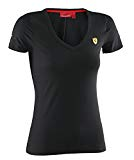

Product Title:  ferrari ladies black vneck tee shirt xlarge 
Brand : Ferrari
color : Black
Euclidean Distance from input image: 4.554333267247748e-08
Amazon Url: www.amazon.com/dp/B01EZ6XKR4
recommendation on the query image


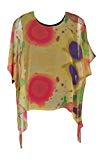

Product Title:  womens abstract art wear silk tunic l  xl oversized fits plus size 
Brand : Cocoon House
color : Multi
Euclidean Distance from input image: 1.1799231018380165
Amazon Url: www.amazon.com/dp/B00U9Q4SXK
recommendation on the query image


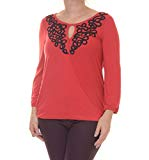

Product Title:  cable  gauge womens soutache trim surplice pullover top red 
Brand : Cable & Gauge
color : Scarlet Rag
Euclidean Distance from input image: 1.3510155466341616
Amazon Url: www.amazon.com/dp/B01M1HRZHU
recommendation on the query image


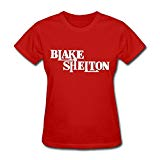

Product Title:  blake shelton new woman season red 
Brand : CS
color : Red
Euclidean Distance from input image: 1.3645321306854827
Amazon Url: www.amazon.com/dp/B01E6IGDAC
recommendation on the query image


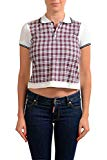

Product Title:  dsquared2 womens plaid front short sleeve polo shirt us xs 38 
Brand : DSQUARED2
color : Multi-color
Euclidean Distance from input image: 1.3731360413503764
Amazon Url: www.amazon.com/dp/B074637K41
recommendation on the query image


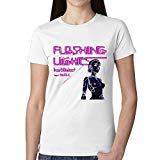

Product Title:  flashing lights kanye west shirts women white 
Brand : Moonflow
color : White
Euclidean Distance from input image: 1.3865711641627432
Amazon Url: www.amazon.com/dp/B01H2WLCQO
recommendation on the query image


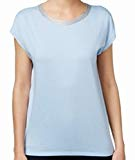

Product Title:  michael kors shore womens embellishedneck knit top blue xs 
Brand : Michael Kors
color : Blue
Euclidean Distance from input image: 1.3909247831844478
Amazon Url: www.amazon.com/dp/B01MRMKVPA
recommendation on the query image


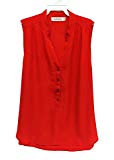

Product Title:  stylesilove sleeveless loose womens top blouse red 
Brand : stylesilove
color : Red
Euclidean Distance from input image: 1.4009320477827638
Amazon Url: www.amazon.com/dp/B01JMU2RW2
recommendation on the query image


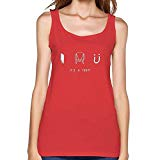

Product Title:  niceda womens owsla design tank top shirt 
Brand : Niceda
color : Red
Euclidean Distance from input image: 1.4045063938577587
Amazon Url: www.amazon.com/dp/B01KV6B7X6
recommendation on the query image


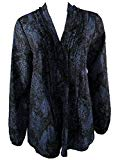

Product Title:  tahari pinky blouse snake print top shirt small navy blue 
Brand : T Tahari
color : Navy Blue
Euclidean Distance from input image: 1.4071881765612846
Amazon Url: www.amazon.com/dp/B00MLC0ZM8
recommendation on the query image


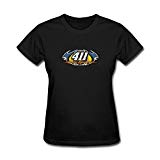

Product Title:  xiuluan womens 411 motor speedway race logo tshirt size xxl colorname short sleeve 
Brand : XIULUAN
color : Black
Euclidean Distance from input image: 1.4074427507622496
Amazon Url: www.amazon.com/dp/B01J3N55VI
recommendation on the query image


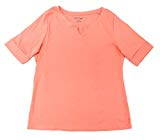

Product Title:  ellen tracy womens size large elbow sleeve top coral pink 
Brand : Emily Rose
color : Coral Pink
Euclidean Distance from input image: 1.4110879087341686
Amazon Url: www.amazon.com/dp/B06Y1V2X9S
recommendation on the query image


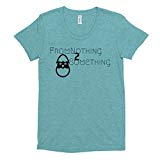

Product Title:  fromnothing 2 something triblend womens short sleeve soft tshirt 50 polyester 25 cotton25 rayon 
Brand : Bazz Fits
color : Evergreen
Euclidean Distance from input image: 1.412161986011952
Amazon Url: www.amazon.com/dp/B06X9P2T71
recommendation on the query image


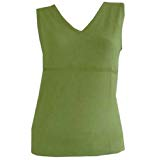

Product Title:  marrikas viscose bamboo sleeveless tank top lime medium 1012 
Brand : Marrikas
color : Green
Euclidean Distance from input image: 1.4127374950931064
Amazon Url: www.amazon.com/dp/B003T8OC40
recommendation on the query image


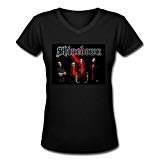

Product Title:  cling womens shinedown world tour 2016 vneck tshirt black 
Brand : CLIng
color : Black
Euclidean Distance from input image: 1.4149787045656943
Amazon Url: www.amazon.com/dp/B01FFHW67C
recommendation on the query image


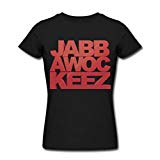

Product Title:  womans jabbawockeez red logo shirts black xxl 
Brand : vcord
color : Black
Euclidean Distance from input image: 1.416227745936026
Amazon Url: www.amazon.com/dp/B01L387BGS
recommendation on the query image


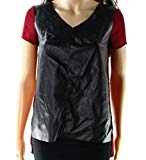

Product Title:  soprano black junior fauxleather ss vneck blouse red xs 
Brand : Soprano
color : Black
Euclidean Distance from input image: 1.4166124240503548
Amazon Url: www.amazon.com/dp/B071Z8NX2P
recommendation on the query image


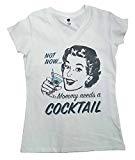

Product Title:  mothers day mommy needs cocktail graphic tshirt  small 
Brand : Mother's Day
color : White
Euclidean Distance from input image: 1.4222597287119172
Amazon Url: www.amazon.com/dp/B01DDZ4RM0
recommendation on the query image


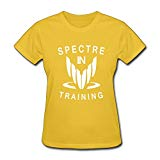

Product Title:  hnan womens mass effect spectre short sleeve tees yellow l 
Brand : H'nan
color : Yellow
Euclidean Distance from input image: 1.4241620383566722
Amazon Url: www.amazon.com/dp/B012CHIJFQ
recommendation on the query image


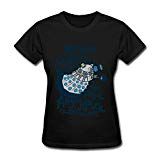

Product Title:  hnan womens doctor logo words oneck tshirts black xl 
Brand : H'nan
color : Black
Euclidean Distance from input image: 1.4242368029371344
Amazon Url: www.amazon.com/dp/B0142LRYRO


In [15]:
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo
''

def get_similar_products_cnn(doc_id,wt,wb,wc,wi,num_results):
    doc_id = asins.index(df_asins[doc_id])
    idf_w2v_dist=pairwise_distances(w2v_title_weight,w2v_title_weight[doc_id].reshape(1,-1))
    brand_dist=pairwise_distances(brand_features,brand_features[doc_id])
    color_dist=pairwise_distances(color_features,color_features[doc_id])
    image_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    pairwise_dist=(wt * idf_w2v_dist +  wb * brand_dist + wc*color_dist + wi*image_dist)/float(wt+wb+wc+wi)

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title','brand','color']].loc[data['asin']==asins[indices[i]]]
        if i==0:
            print("query image")
        else:
            print("recommendation on the query image")
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'],)
            print('Brand :',row['brand'])
            print('color :',row["color"])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amazon.com/dp/'+ asins[indices[i]])


text_weight=int(input("enter the weight of the text:"))
brand_weight=int(input("enter the weight of brand:"))
color_weight=int(input("enter the weight of the color:"))
image_weight=int(input("enter the weight of the image:"))

get_similar_products_cnn(19,text_weight,brand_weight,color_weight,image_weight,20)


